# FargoCPT Quickstart

This notebook guides you through how to make the code, run a simulation and plot the results.

First we create a new directory and change to it.

In [1]:
example_name = "100_quickstart"
!mkdir -p $example_name
import os
os.chdir(example_name)

## Make the code

Make sure the code is built by running make again.

If you have not yet compiled the go, please go to the readme and follow the instructions there.
You can also try to run the following cell directly, but it will only output error messages. This might make debugging harder.

In [2]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C ../../src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

367 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Preparing a setup file

We'll take the example setup file from the examples directory and modify it in python.
If you want to create setup files for a parameter study, just copy the code and make your own setup creator script.

In [3]:
configfile = "setup.yml"
!cp ../config.yml $configfile

We'll use the `ruamel.yaml` package to read and write the setup file. This can be set up to preserve comments which is very useful if you want to trace your decisions later on.

In [4]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yaml = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yaml.load(infile)

In [5]:
config["nbody"][1]["accretion efficiency"] = "2"
config["DT"] = 0.314 # monitor scalar files around every half orbit
config["Ninterm"] = 20 # write a snapshot every orbit
config["Ntot"] = 100 # wirte 100 snapshots
# use very low resolution by setting it to 2 cell per scaleheight, cps
try:
    del config["Nrad"]
except KeyError:
    pass
try:
    del config["Nsec"]
except KeyError:
    pass

config["cps"] = 2

with open(configfile, "w") as outfile:
    yaml.dump(config, outfile)

## Running the code

We can start fargo using the python interface.

For a production, uncomment the following cell and copy the command to your start script.

In [7]:
# cwd = os.getcwd()
# cmd = f"cd {cwd} && python3 ../../run_fargo -np 1 -nt 4 auto {configfile}"
# print(cmd)

Here, we just launch the code from within the notebook.

Note the `detach=True` parameter.
This sets the simulation up to run in the background.
Use `detach=False` to see the output in the notebook.

Here we opt to detach the simulation to be able to use the widget below to have some live view into the simulation.

In [8]:
import sys
sys.path.append("../../bin")
from fargocpt import run_fargo
run_fargo(2, 1, ["start", configfile], detach=True)

Running command: mpirun -np 2 --report-pid - -x OMP_NUM_THREADS=1 /workspaces/fargocpt/bin/fargocpt start setup.yml
detaching...


Following is an overview widget for the simulation. You can use the slider to scrub through the different snapshots.

In [27]:
import sys
sys.path.append("../../Tools")
from overview import Overview

Run the next cell again to refresh the snapshot list.

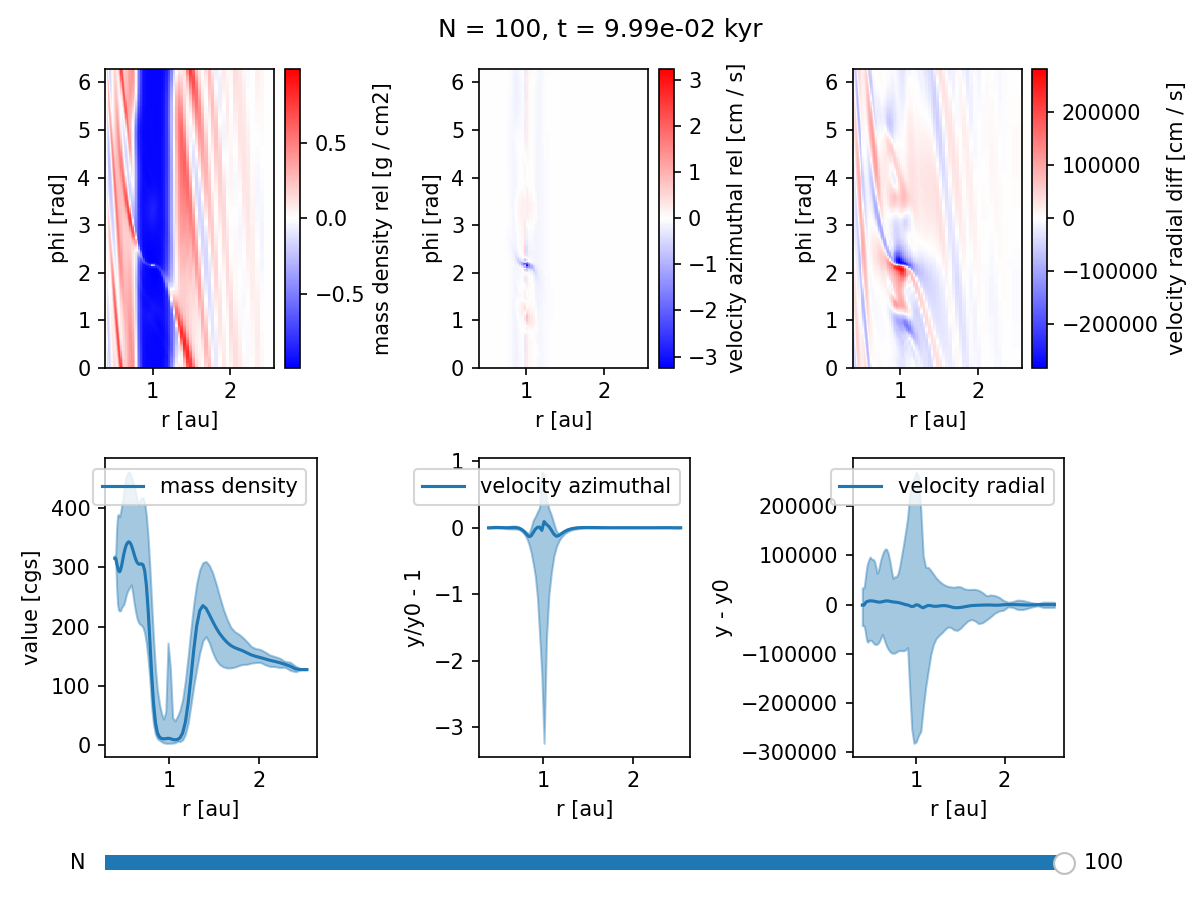

In [28]:
%matplotlib widget
overview = Overview("output/out/", 
                    vars=["2:mass density:rel,rphi",
                          "2:velocity azimuthal:rel,rphi",
                          "2:velocity radial:diff,rphi",
                          "1:mass density:minmax",
                          "1:velocity azimuthal:rel,minmax",
                          "1:velocity radial:diff,minmax"])
overview.create()

## The output directory structure

The following cell will stop the notebook if the simulation has not been run yet.

In [11]:
if not os.path.exists("output/out/snapshots/list.txt"):
    cwd = os.getcwd()
    cmd = f"cd {cwd} && ../../run_fargo -np 1 -nt 4 start {configfile}"
    raise FileNotFoundError(f"No snapshots found. Please run the simulation first.\n\n{cmd}")

Now, let's have a look at how the output directory is structured.

In [12]:
!ls output/out

Sigma1D.info	fargocpt_output_v1_2  snapshots     vrad1D.info
dimensions.dat	monitor		      units.dat     vtheta1D.info
energy1D.info	parameters	      used_rad.dat


It contains some files describing general properties of the simulation, like 
- the version of the code (`fargocpt_output_v1_2`),
- the dimensions of the grid (`dimensions.dat` and `used_rad.dat`),
- the code units used (`units.dat`),
- and information on 1D output files (`*1D.info`) used to load the corresponding binary files.

There is also a `parameters` directory containing a copy of the setup file used for every start of the simulation.
This way you can easily track how often and at which snapshots you restarted a long run.
Here, we only have one copy.

In [13]:
!ls output/out/parameters

setup.yml


Next, there are snaphost directories, each containing a full snapshot of the system.
Each of these directories can be used to restart the simulation or start a new one.

In [14]:
!ls output/out/snapshots

0    14  20  27  33  4	 46  52  59  65  71  78  84  90  97
1    15  21  28  34  40  47  53  6   66  72  79  85  91  98
10   16  22  29  35  41  48  54  60  67  73  8	 86  92  99
100  17  23  3	 36  42  49  55  61  68  74  80  87  93  damping
11   18  24  30  37  43  5   56  62  69  75  81  88  94  list.txt
12   19  25  31  38  44  50  57  63  7	 76  82  89  95  timeSnapshot.dat
13   2	 26  32  39  45  51  58  64  70  77  83  9   96


The `damping` directory contains a copy of the initial data which is used in the code e.g. for damping to the initial density inside of damping zones close to the boundaries. Copy this aswell, if you want to restart a simulation from a snapshot.

There is `timeSnapshot.dat` file which is a tab separated data file containing the time of the snapshot and the `list.txt` file which is simply a text file which has the number of each snapshot in a separate line. This is useful if you interact with the code using the command line. E.g.

In [15]:
!tail -n 1 output/out/snapshots/list.txt

100


is a clean way to get the number of the last snapshot.

The `snapshots` directory contains 
- the state variables of the hydro simulation (density, energy and velocities), 
- 1D output files, 
- a binary file for each planet and the `rebound.bin` for the state of the integrator (this is used for binary exact restarting)
- the `misc.bin` file which contains the state of the simulation system, e.g. the orientation of the coordinate system w.r.t. to an inertial frame and the last used CFL limited timestep,
- and a copy of the setup at the time of this snapshot.

In [16]:
!ls output/out/snapshots/0

Sigma.dat    energy.dat    planet1.bin	vrad.dat    vtheta1D.dat
Sigma1D.dat  energy1D.dat  planet2.bin	vrad1D.dat
config.yml   misc.bin	   rebound.bin	vtheta.dat


Finally, there is the `monitor` directory which contains monitor variables. These scalar variables are computed from the system state during the simulation and are written more often than the full snapshots.

In [17]:
!ls output/out/monitor

Quantities.dat	planet1.dat  planet2.dat  timeMonitor.dat  timestepLogging.dat


All files have a header that describes the colums and the units of the variables. The header can be automatically parsed.

In [18]:
!head output/out/monitor/timeMonitor.dat

# Time log for course output.
#version: 0.1
#variable: 0 | time step | 1
#variable: 1 | analysis time step | 1
#variable: 2 | physical time | 5.0225669513368811e+06 s
# One DT is 0.314000000000000001 (code) and 1577086.02271978068 (cgs).
# Syntax: coarse output step <tab> fine output step <tab> physical time (code)
0	0	0.0000000000000000e+00
0	1	3.1400000000000000e-01
0	2	6.2800000000000000e-01


- Each planet has its own file,
- disk quantities, e.g. the total mass, are stored in `Quantities.dat`,
- the output times of these fine grained monitor variables are stored in `timeMonitor.dat`, along with the corresponding snapshot number,
- and information about the CFL timestep and the ellapsed walltime can be found in `timestepLogging.dat`.

## Loading data

Let's inspect the monitor quantities that Fargo outputs.
Those are stored in the `monitor` directory within the output dir.

We'll use the `inspect_tab_file.py` tool, which helps navigating the tab separated output files.

Calling this tool with the `monitor/Quantities.dat` file, an overview of the available data is shown.

In [19]:
!python3 ../../Tools/inspect_tab_file.py output/out/monitor/Quantities.dat

Available variables:
 0   time step
 1   analysis time step
 2   physical time
 3   mass
 4   radius
 5   angular momentum
 6   total energy
 7   internal energy
 8   kinematic energy
 9   potential energy
10   radial kinetic energy
11   azimuthal kinetic energy
12   eccentricity
13   periastron
14   viscous dissipation
15   luminosity
16   pdivv
17   inner boundary mass inflow
18   inner boundary mass outflow
19   outer boundary mass inflow
20   outer boundary mass outflow
21   wave damping inner mass creation
22   wave damping inner mass removal
23   wave damping outer mass creation
24   wave damping outer mass removal
25   density floor mass creation
26   aspect ratio
27   indirect term nbody x
28   indirect term nbody y
29   indirect term disk x
30   indirect term disk y
31   frame angle
32   disk eccentricity
33   disk periastron
34   advection torque
35   viscous torque
36   gravitational torque


In [20]:
!python3 ../../Tools/inspect_tab_file.py output/out/monitor/Quantities.dat 2 3 --units kyr solMass | head

         0 kyr	  0.000349 solMass
     5e-05 kyr	  0.000349 solMass
  9.99e-05 kyr	  0.000349 solMass
   0.00015 kyr	  0.000349 solMass
    0.0002 kyr	  0.000349 solMass
   0.00025 kyr	  0.000349 solMass
    0.0003 kyr	  0.000349 solMass
   0.00035 kyr	  0.000349 solMass
    0.0004 kyr	  0.000349 solMass
   0.00045 kyr	  0.000349 solMass


Now let's use another an external tool to conveniently load data from the simulations output.
Disclaimer, I (Thomas Rometsch) wrote the tool. Feel free to just use `np.genfromtxt` to load the time series data.

We'll first create a Data object and ask what's available in the output. 

In [21]:
try:
    from disgrid import Data
except ImportError:
    raise ImportError("Please install disgrid with `python3 -m pip install git+https://github.com/rometsch/disgrid`")
d = Data("output/out")
d.avail()

{'fluids': {'gas': {'2d': ['dens', 'energy', 'vrad', 'vtheta'],
   '1d': ['ma', 'rgy', 'd', 'eta'],
   'scalar': ['time step',
    'analysis time step',
    'physical time',
    'mass',
    'radius',
    'angular momentum',
    'total energy',
    'internal energy',
    'kinematic energy',
    'potential energy',
    'radial kinetic energy',
    'azimuthal kinetic energy',
    'eccentricity',
    'periastron',
    'viscous dissipation',
    'luminosity',
    'pdivv',
    'inner boundary mass inflow',
    'inner boundary mass outflow',
    'outer boundary mass inflow',
    'outer boundary mass outflow',
    'wave damping inner mass creation',
    'wave damping inner mass removal',
    'wave damping outer mass creation',
    'wave damping outer mass removal',
    'density floor mass creation',
    'aspect ratio',
    'indirect term nbody x',
    'indirect term nbody y',
    'indirect term disk x',
    'indirect term disk y',
    'frame angle',
    'disk eccentricity',
    'disk periastro

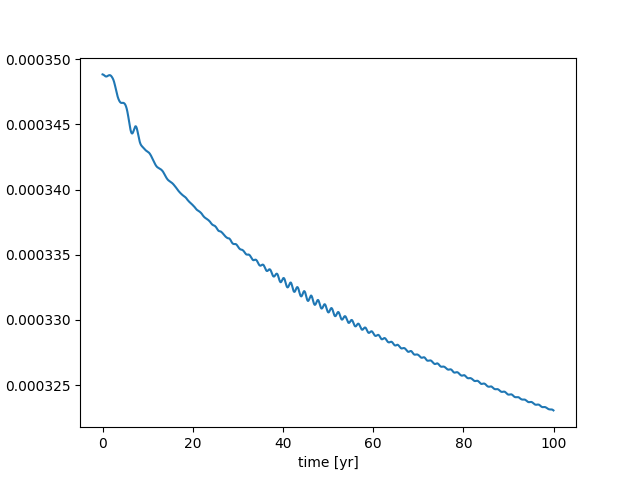

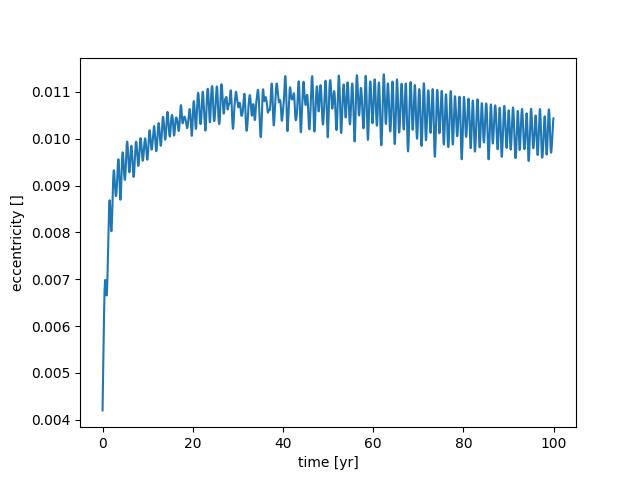

In [22]:
import matplotlib.pyplot as plt

for varname in ["mass", "eccentricity"]:
    fig, ax = plt.subplots()
    x = d.get(dim="scalar", var=varname)
    ax.plot(x.time.to("yr"), x.data)
    ax.set_ylabel(f"{varname} [{x.data.unit}]")
    ax.set_xlabel(f"time [yr]")

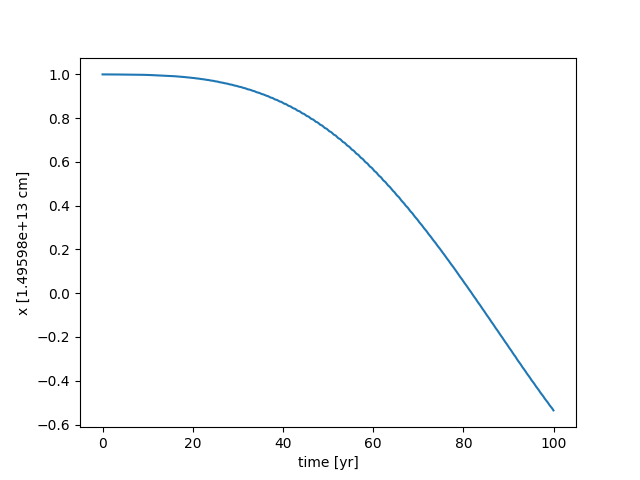

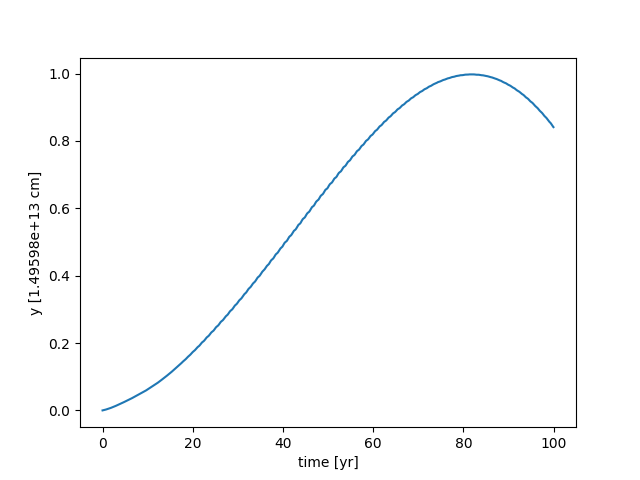

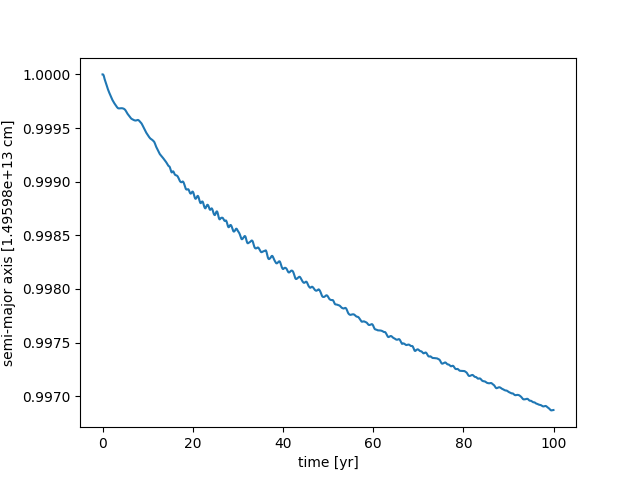

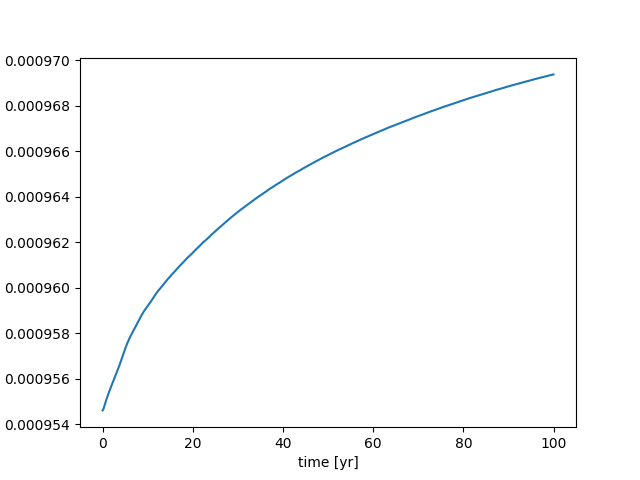

In [23]:
n_planet = 1
for varname in ["x", "y", "semi-major axis", "mass"]:
    fig, ax = plt.subplots()
    x = d.get(dim="scalar", var=varname, planet=n_planet)
    ax.plot(x.time.to("yr"), x.data)
    ax.set_ylabel(f"{varname} [{x.data.unit}]")
    ax.set_xlabel(f"time [yr]")

In [24]:
import numpy as np
import matplotlib.colors as mplcolors

def plot_field(data, name, N, ax=None, dataunit=None, vmin=None, vmax=None, cmap="viridis"):
    field = data.get(var=name, dim="2d", N=N)
    if dataunit is None:
        dataunit = field.data.unit
    Z = field.data.to_value(dataunit)

    ri = field.grid.get_interfaces("r").to_value("au")
    phii = field.grid.get_interfaces("phi").to_value("rad")
    PHI, R = np.meshgrid(phii, ri)
    X = R*np.cos(PHI)
    Y = R*np.sin(PHI)

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    else:
        fig = ax.get_figure()

    norm = mplcolors.Normalize(vmin=vmin, vmax=vmax)
    pcm = ax.pcolormesh(X,Y,Z, norm=norm, cmap=cmap)
    ax.set_aspect("equal")

    t = field.time.to_value("kyr")
    ax.set_title(f" t={t:.2e}kyr, N={N}")

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(f"{name} [{dataunit}]")
    
    return fig

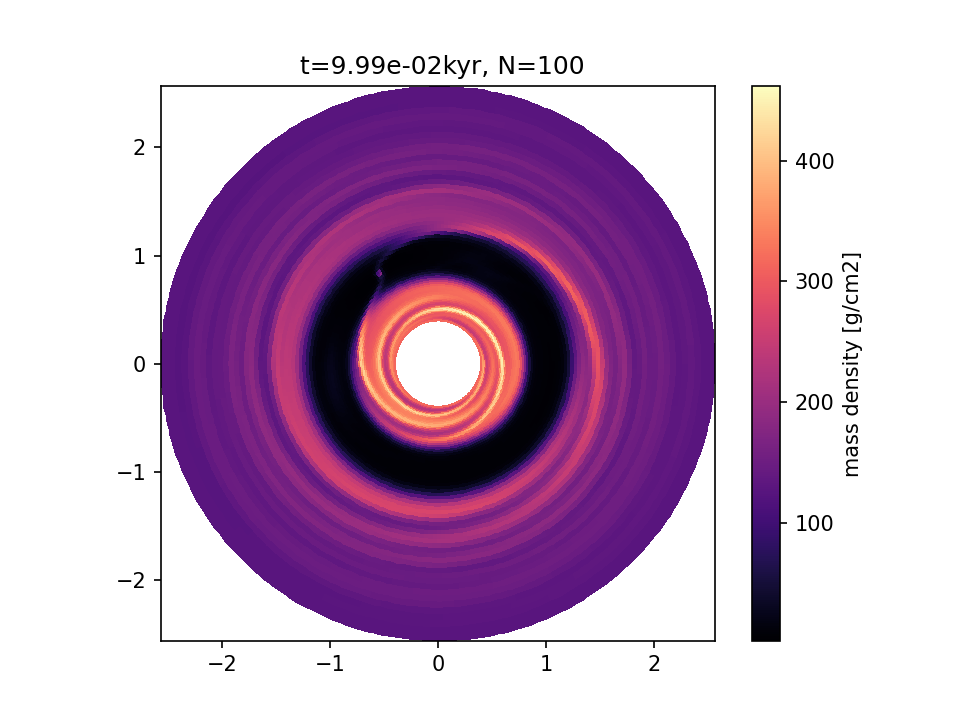

In [25]:
Nlast = d.avail()["Nlast"]
plot_field(d, "mass density", Nlast, dataunit="g/cm2", cmap="magma");

Text(0, 0.5, '$\\Sigma$ [g/cm2]')

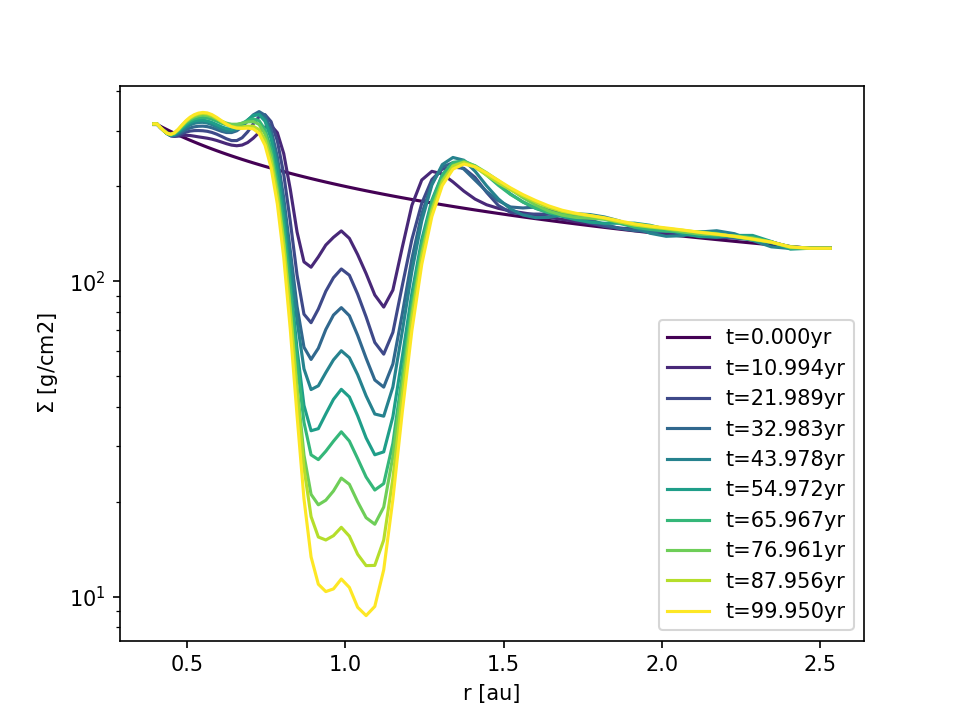

In [26]:
import matplotlib

name = "mass density"
dataunit = "g/cm2"

Nfirst = d.avail()["Nfirst"]
Nlast = d.avail()["Nlast"]

fig, ax = plt.subplots(dpi=150)

field = d.get(dim="2d", var="mass density", N=0)
profile0 = np.average(field.data.to_value(dataunit), axis=1)

cmap = matplotlib.pyplot.get_cmap("viridis")

inds = np.linspace(Nfirst, Nlast, 10, dtype=int)
for k, n in enumerate(inds):
    color = cmap(k/(len(inds)-1))
    
    field = d.get(dim="2d", var="mass density", N=n)
    r = field.grid.get_centers("r").to_value("au")
    Z = field.data.to_value(dataunit)
    
    y = np.average(Z, axis=1)
    
    t = field.time.to_value("yr")
    # ax.plot(r, (profile-profile0)/profile0, label=f"t={t:.3f}yr")
    line, = ax.plot(r, y, label=f"t={t:.3f}yr", color=color)
    
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("r [au]")
ax.set_ylabel(fr"$\Sigma$ [{dataunit}]")

Concratulations! You've made it through the quickstart guide.
You should now know enough to run your own experiments using the FargoCPT code.
Happy experimenting!